In [1]:
##### Visual String Pot
# This program takes an image and finds the centre of an orange stripe and green dot. It then use the length of the orange stripe to scale the difference between the clusters to calculate the length.
# it uses FAISS kmeans clustering to find a cluster of the approximate size of the stripe and dot.
# the stripe and dot are then rotated onto the principle component of the stripe
# the user defines a reduction and enchancment factotor which reduces the numbe rof pixcel and enchances the colours when the images are imported.
# the uses then defines the window to focus clustering and the aprox dimensions of the striope and dot
# the results are then exported as a csv with index, fileName, timeStamp, measurement, dotMedian, stripeMedian, scale, dotLength,

In [2]:
## Import packages and set up environemnt
from os import listdir
from os.path import isfile, join
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd
from IPython.display import clear_output
import time
import faiss
import dask.array as da
from sklearn.decomposition import PCA


In [3]:
## define functions
def loadImages(directory, file_list, sample, reduction, enchanced, dim, ench_type):
    ## Function takes file list and if samples --> loads sample, otherwise loads all images in file list, reducing by the reduction factor and enchancing by the enchance factor. If dim --> crops image otherwise entire image is loaded

    timeStamp = [] # create empty list for time stamps
    index = 0 # set index to zero, used as counter for assignemnt  to array


    if not sample:  # if sample does not exist create a list of numbers to load
        sample = range(len(file_list))  # make sample the entire file list

    if not dim:  # open an image and get the image dimensions if no cropping is supplied
        image = np.array(Image.open(directory+file_list[0]).reduce(int((reduction))))  # load image to array
        h, w, d = tuple(image.shape) # get shape of image in file
        dim = [0, h, 0, w,] # assign shape to dim list so entire image is imported

    # Create empty NP array for pixcels. All pictures are loaded into an array height, width, # images, colours
    pixcels = np.empty((dim[1] - dim[0], # number of rows
                        dim[3] - dim[2], # number of columns
                        len(sample), # number of images
                        3), # number of colour arrays per image + 3 for x and y and l
                       dtype='float32')

    for sam in sample:  # loop over each file in file_list
        clear_output(wait=True)  # clear output
        file = file_list[sam]  # set file as the sam'th entry in file list
        file_path = directory + file  # define file path
        ts = Image.open(file_path)._getexif()[36867]  # import timestamp as tS

        if enchanced:  # if an enchancments is call
            #open image and create enchancer
            if ench_type == 'Bright':
                enchancer = ImageEnhance.Brightness(Image.open(file_path).reduce(int((reduction))))
                image = np.array(enchancer.enhance(enchanced))  # load image and convert to array

            else:
                enchancer = ImageEnhance.Contrast(Image.open(file_path).reduce(int((reduction))))
                image = np.array(enchancer.enhance(enchanced))  # load image and convert to array

        else: # if no enchancement is called
            image = np.array(Image.open(file_path).reduce(int((reduction))))  # load image into array
        # crop array and load into pixcels array
        pixcels[:, :, index, :] = image[dim[0] : dim[1],
                                  dim[2] : dim[3],
                                  :]

        timeStamp.append(ts)  # append time stamp to list
        index += 1
        print("importing " + file + " file # " + str(sam + 1) + " of " + str(len(file_list) + 1))
        print(ts)
    return (timeStamp, pixcels)

def plotSamples(imgArr, ticks, title, titleData):
    ## function takes image array and plots images over 2 columns and as many rows as required. user selects if ticks and headings --> supply heading data in list form

    sampleSize = imgArr.shape[2]  # return the 3rd dimension of the array
    width = 2 # set number of columns to plot
    height = int(sampleSize/width) # determine how many rows to plot
    index = 0 # set a counter to 0
    plt.close()  # close previous plot
    f, axarr = plt.subplots(height, width)  # create enough rows to plot all samples
    for row in range(0,height):  # iterate over each image row
        for h in range(0,height): # iterare over each column
            axarr[h,row].imshow(imgArr[:, :, index, :].astype('uint8'))  # open image and plot
            if title:
                axarr[h, row].title.set_text(titleData[row])

            if not ticks:
                axarr[h, row].set_xticks([])
                axarr[h, row].set_yticks([])
            
            index += 1 # increase counter by 1

def clus2Image(clussArr, centers, recolour_dict):
    ## defien function to take an array of cluster labels and centers and return an image array, with specified clusters recoulured if required
    if recolour_dict: # if recolour provided
        for key in recolour_dict.keys(): # iterate over each key value pair
            centers[key] = np.asarray(recolour_dict[key]) # change the value of that center to the specified colour

    imgArr = centers[clussArr]

    return(imgArr)

def faissCluster(pixcels,frac, startClus, noIt):
    ## defien function to perfrom kmeans clustering using faiss
    no_clusters = startClus # set inital number of clusters
    no_iterations = noIt # set the no of iterations for each step of kmeans
    clusterMin = 1000 # set cluster min to enter while loop
    d = pixcels.shape[1]



    while clusterMin > frac:  # continue to increase number of clusters until the smallest cluster becomes sufficently small to just be the stripe
        #clear_output(wait=True)  # clear output
        print('clustering with '+str(no_clusters)+"\n")
        kmeans = faiss.Kmeans(d, no_clusters, niter=no_iterations, verbose=True) # define faiss kmeans object
        kmeans.train(pixcels) # train kmeans object
        D, I = kmeans.index.search(pixcels, 1) # return kmeans
        pixInClus = np.unique(I, return_counts=True) # get counts # pixels in each cluster
        #colour = np.where(pixInClus[1] == min(pixInClus[1])) # assigns the smallest cluster as the stripe colour
        colour = np.where(abs(pixInClus[1] / pixInClus[1].sum() - frac) == abs(pixInClus[1] / pixInClus[1].sum() - frac).min())
        clusterMin = min(pixInClus[1]) / (h*w*l) # Calcultes the fraction of the picture occupied the the stripeColour
        no_clusters += 1 # Increase number of clusters by 1
        print("Cluster Min was "+str(clusterMin)+"\n")
              
    return(D, I, kmeans, colour)

def cleanIQR(upper, lower, singleValues, inplace, verb):

    iqr = np.subtract(*np.percentile(singleValues, [upper, lower]))
    med = np.percentile(singleValues, 50)
    minus = med - iqr
    plus = med + iqr
    toKeep = (minus < singleValues) & (singleValues < plus)
    if verb:
        plt.close()
        f, axarr = plt.subplots(2)  # create enough rows to plot all samples
        axarr[0].boxplot(singleValues)
        axarr[1].boxplot(singleValues[(minus < singleValues) & (singleValues < plus)])
        print('The min projected y value before cleaning is '+str(singleValues.min()))
        print('The max projected y value before cleaning is '+str(singleValues.max()))
        print('The min projected y value after cleaning is '+
              str(singleValues[(minus < singleValues) & (singleValues < plus)].min()))
        print('The max projected y value after cleaning is '+
              str(singleValues[(minus < singleValues) & (singleValues < plus)].max()))

    if inplace:
        return(singleValues[(minus < singleValues) & (singleValues < plus)])
    else:
        return(toKeep)

def addInd(w,h,l, pixcels, Vh):
    ## define function to add x and y cordinated, projected onto second principle component of the stripe to the pixcels array so as geometric position has an effect
    i, j, p = np.meshgrid(range(w),range(h),range(l)) # use mesh grid to creat arrays of indices
    i= np.reshape(i, (w*h*l,1)).astype('float32') # reshape x ind to match reshaped pixcels
    j= np.reshape(j, (w*h*l,1)).astype('float32') # reshape y ind to suit reshaped pixcels
    dot_search = np.hstack((j,i)) # stack ontop
    del i
    del j
    del p
    dot_search = dot_search @Vh[:,1] # multiply by rotation vector
    plt.close()
    plt.boxplot(dot_search) # plot to check range
    dot_search = np.interp(dot_search, (dot_search.min(), dot_search.max()), (-1,1))
    print('scaled min of dot_search is '+str(dot_search.min()))
    print('scaled max of dot_search is '+str(dot_search.max()))

    dot_search = np.reshape(dot_search,(h*w*l,1))
    dot_search= np.hstack((pixcels,dot_search))

    return(dot_search.astype('float32'))

In [4]:
## define working directory and which files to sample
job = '220420-LR-Sailtesting'
directory = '/mnt/veeringDL_storage/220420-mg/' # define directory
out_dir = '/mnt/home/9.0 Data Jobs/'+job+'/'
file_list = [f for f in listdir(directory) if isfile(join(directory, f))] # inspect directory and return list of files
print(str(len(file_list))+' Images found in folder')

7771 Images found in folder


In [5]:
## user defines which images to sample
sample = [10,2000,5000,7000] # Set which 4 images to sample

importing G0021315.JPG file # 7001 of 7772
2022:04:20 15:26:07


<IPython.core.display.Javascript object>


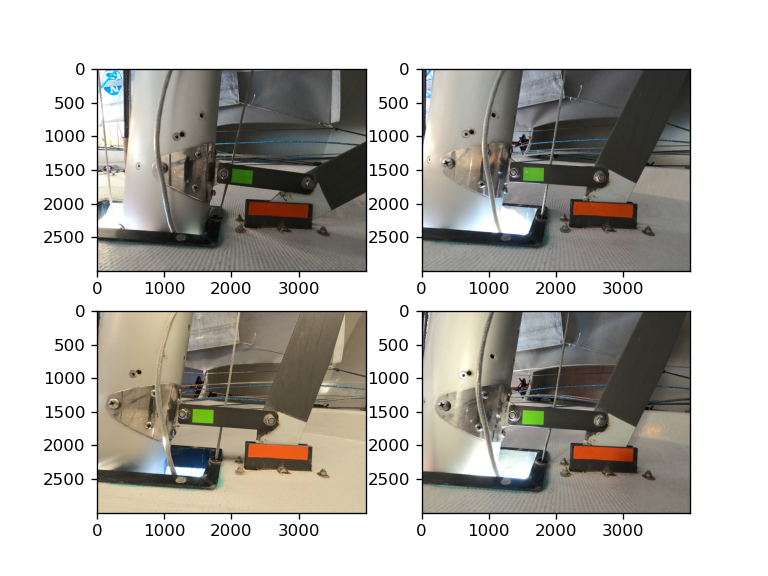

In [6]:
## load sample images and plot
timeStamp, pixcels = loadImages(directory, file_list, sample, 1, False, False, False)
plotSamples(pixcels, True, False, False)

importing G0021315.JPG file # 7001 of 7772
2022:04:20 15:26:07


<IPython.core.display.Javascript object>


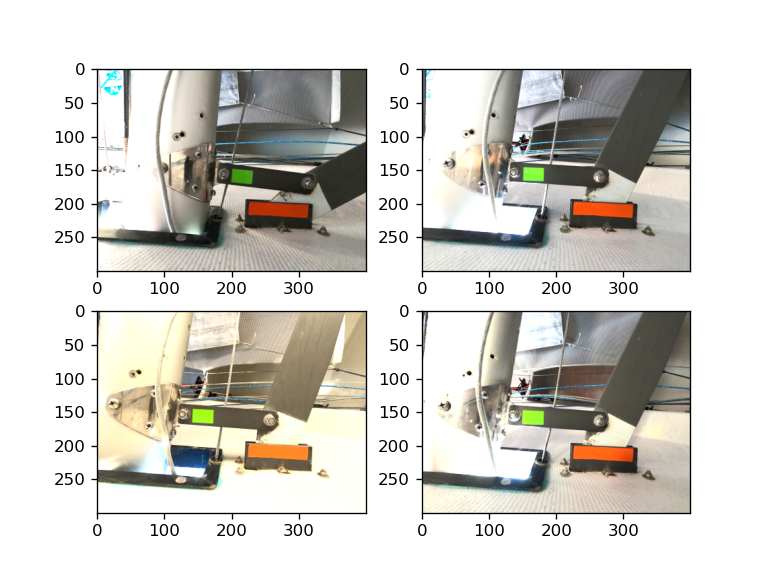

In [10]:
reduction = 10
enchancement =1.5
ench_type = 'Bright'
## load sample images and plot
timeStamp, pixcels = loadImages(directory, file_list, sample, reduction, enchancement, False, ench_type)
plotSamples(pixcels, True, False, False)

importing G0021315.JPG file # 7001 of 7772
2022:04:20 15:26:07


<IPython.core.display.Javascript object>


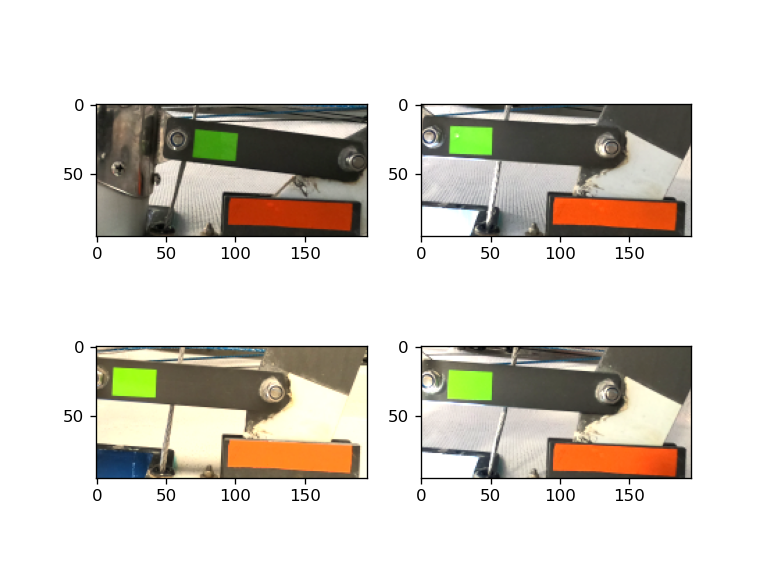

In [12]:
h1 = 130 # horizontal to start image at
h2 = 325 # horizontal to end image at
v1 = 130 # vertical to start image at
v2 = 225 # vertical to end image at
dim = [v1, v2, h1, h2] # make dim variable as list to pass to load images
timeStamp, pixcels = loadImages(directory, file_list, sample, reduction, enchancement, dim, ench_type)
plotSamples(pixcels, True, False, False)

In [13]:
stripe_left = 95 # left bound of stripe
stripe_right = 185 # right bound of stripe
stripe_top = 72 # top bound of stripe
stripe_bottom = 92 # bottom bound of stripe
dot_left = 13 # left bound dot
dot_right = 43 # right bound of dot
dot_top = 17 # top bound of dot
dot_bottom = 36 # bottom bound of dot
area_factor = 1.1 # factor to multiply aproximmated area by
stepAfterStripeCluss = 1
stripe_area = abs(stripe_right - stripe_left) * abs(stripe_bottom - stripe_top) # calcluate area of stripe in pixcels
dot_area = abs(dot_right - dot_left) * abs(dot_bottom - dot_top) # calculate area of dot in pixcels
fig_area = abs(v2-v1) * abs(h2-h1) # calculate area of figure with
stripeFrac = area_factor * stripe_area / fig_area # expected fraction of image to be the stripe
dotFrac = area_factor * dot_area / fig_area # expected fraction of image to be the dot

print("The stripe fraction used is "+str(stripeFrac))
print("the dot fraction used is "+str(dotFrac))
print(fig_area)
print(dot_area)

The stripe fraction used is 0.10688259109311742
the dot fraction used is 0.033846153846153845
18525
570


importing G0023550.JPG file # 7771 of 7772
2022:04:20 16:03:22


<IPython.core.display.Javascript object>


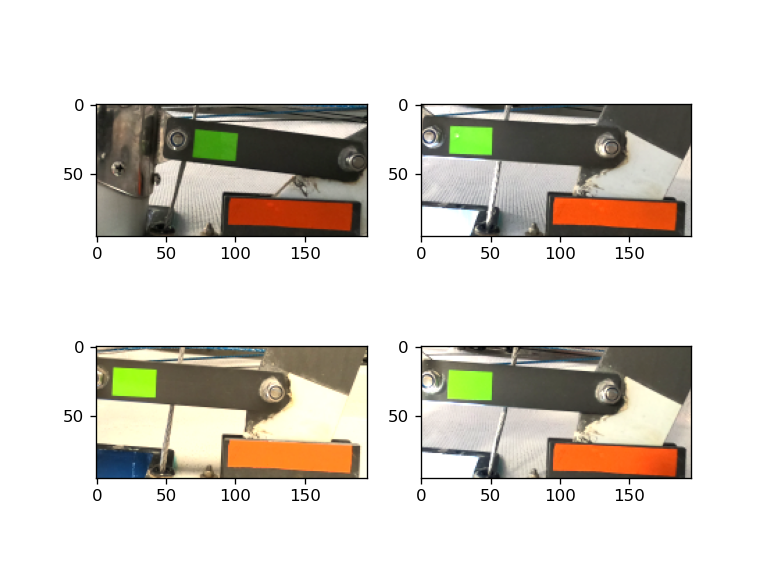

In [14]:
## load all images and plot samples to check cropping
timeStamp, pixcels = loadImages(directory, file_list, False, reduction, enchancement, dim, ench_type)
plotSamples(pixcels[:,:,sample,:], True, False, False)

In [15]:
pixcels = (pixcels - pixcels.mean(axis=(0,1,2), keepdims=True )) / pixcels.std(axis = (0,1,2))


<IPython.core.display.Javascript object>


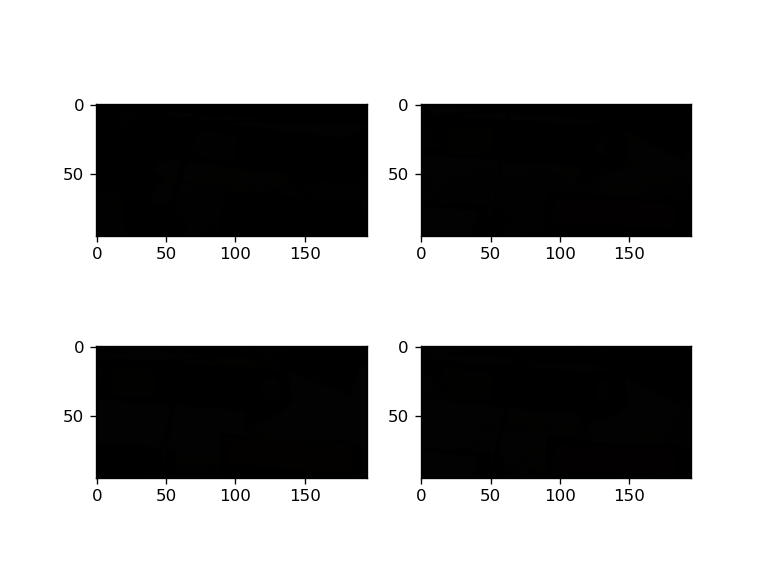

In [16]:
plotSamples(pixcels[:,:,sample,:], True, False, False)

In [17]:
h, w, l, d = orig_shape = tuple(pixcels.shape) # get shape of pixcels array

clustering with 3

Sampling a subset of 768 / 143957775 for training
Clustering 768 points in 3D to 3 clusters, redo 1 times, 10 iterations
  Preprocessing in 2.65 s
Cluster Min was 0.21877058741703947s): objective=330.658 imbalance=1.140 nsplit=0       

clustering with 4


Sampling a subset of 1024 / 143957775 for training
Clustering 1024 points in 3D to 4 clusters, redo 1 times, 10 iterations
  Preprocessing in 5.65 s
Cluster Min was 0.09069140586536573s): objective=298.025 imbalance=1.230 nsplit=0       



<IPython.core.display.Javascript object>


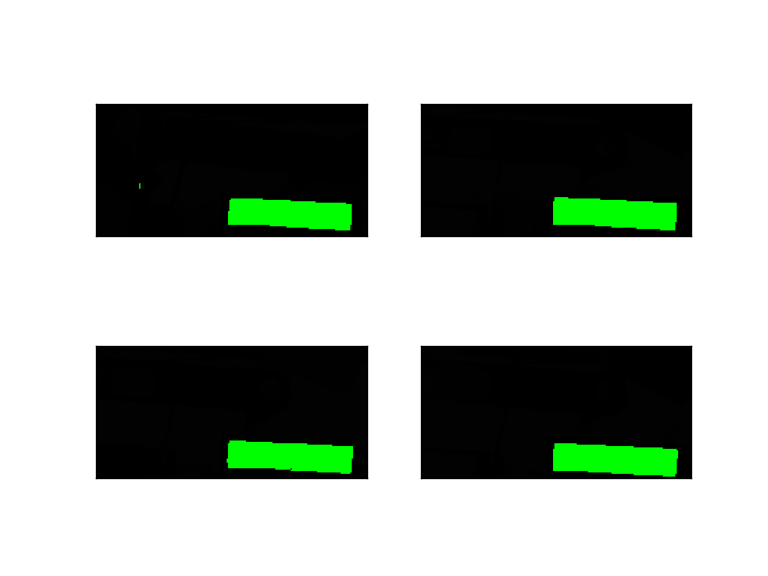

In [18]:
## use faiss kmeans clustering to find all stripe clusters
it = 10 # # interations to perform in clustering
stripe_startNo = 3 # number of initial clusters

## do i add x and y positions??
## do i need to scale if including x and y positions, yes you do you numpty nearly order magnitude difference
pixcels = np.reshape(pixcels, (h*w*l, d)) # reshape and change data type of pixcdls to suit faiss kmeans
D, I, kmeans, stripeColour =  faissCluster(pixcels, stripeFrac, stripe_startNo, it) # perform faiss clustering looking for stripe
check = clus2Image(I, kmeans.centroids, {int(stripeColour[0][0]): [0,255,0]}) # get image array with stripe clusters changed to green
check = np.reshape(check, orig_shape) # reshape for plotting
check = check[:,:,sample,:] # reduce to just sample images
plotSamples(check, False, False, False) # plot sample images to check clustering

In [19]:
## use dask svd to find roation matrix and then calculayte stripe length and median
stripe_loc = np.array(np.where(np.reshape(I, (h,w,l)) == stripeColour)) # get stripe locations from reshaped labels array

The scale used is -1.0467468896482486 mm/pixcel


<IPython.core.display.Javascript object>


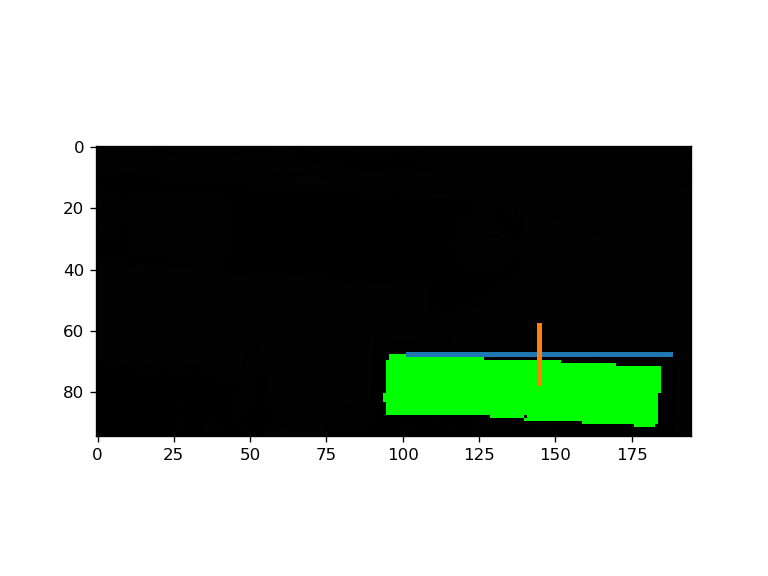

In [22]:

pca = PCA(2)
pca.fit(stripe_loc[0:2,:].T)
Vh = pca.components_

perpClean_min = 25
perpClean_max = 75
rotClean_min = 26
rotClean_max = 75
stripe_perp = stripe_loc[0:2,:].T @ Vh[:,1] # rotate stripe onto second principle component of stripe to clean
stripe_perp = cleanIQR(perpClean_max,perpClean_min,stripe_perp, False, False) # remove outliers from stripe rot
stripe_rot = stripe_loc[0:2,:].T @ Vh[:,0] # rotate stripe onto first principle component
stripe_rot = stripe_rot[stripe_perp]
stripe_rot = cleanIQR(rotClean_max,rotClean_min,stripe_rot, True, False)

stripeMedian = np.median(stripe_rot) # find median of the stripe
stripe_len = (abs(abs(np.min(stripe_rot)) - abs(np.max(stripe_rot)))) # finds the abs range of the stripe (known length)
scale = knownLength / stripe_len # calculate the pixcel to mm scale
print('The scale used is '+str(scale)+' mm/pixcel')
## plot sample images with the principle componets on it for assesment
stripe_perp = stripe_loc[0:2,:].T @ Vh[:,1] # rotate stripe onto second principle component of stripe to clean
stripe_perp = cleanIQR(perpClean_max,perpClean_min,stripe_perp, True, False) # remove outliers from stripe rot
stripePlot = [stripe_rot.min(),stripe_rot.max(), np.median(stripe_perp), stripe_perp.min(),stripe_perp.max(), stripeMedian]
plt.close()
plt.imshow(check[:, :, 1, :].astype('uint8'))
plt.plot([np.array([stripePlot[0],0]) @ np.linalg.inv(Vh)[1],
          np.array([stripePlot[1],0]) @ np.linalg.inv(Vh)[1]],
         [np.array([0,stripePlot[2]]) @ np.linalg.inv(Vh)[0],
          np.array([0,stripePlot[2]]) @ np.linalg.inv(Vh)[0]], linewidth = 3)

plt.plot([np.array([stripePlot[5],0]) @ np.linalg.inv(Vh)[1],
          np.array([stripePlot[5],0]) @ np.linalg.inv(Vh)[1]],
         [np.array([0,stripePlot[3]]) @ np.linalg.inv(Vh)[0],
          np.array([0,stripePlot[4]]) @ np.linalg.inv(Vh)[0]], linewidth = 3)

In [23]:
stripe_loc = np.array(np.where(np.reshape(I, (h,w,l)) == stripeColour)) # get stripe locations from reshaped labels array

perpClean_min = 25
perpClean_max = 75
rotClean_min = 26
rotClean_max = 75
stripe_perp = stripe_loc[0:2,:].T @ Vh[:,1] # rotate stripe onto second principle component of stripe to clean
stripe_perp = cleanIQR(perpClean_max,perpClean_min,stripe_perp, False, False) # remove outliers from stripe rot
stripe_perp = np.vstack((stripe_perp,stripe_perp,stripe_perp))
stripe_loc = np.reshape(stripe_loc[stripe_perp],(3,-1))
stripe_rot = stripe_loc[0:2,:].T @ Vh[:,0] # rotate stripe onto first principle component
stripe_rot = cleanIQR(rotClean_max,rotClean_min,stripe_rot, False, False)
stripe_rot = np.vstack((stripe_rot,stripe_rot,stripe_rot))
stripe_loc = np.reshape(stripe_loc[stripe_rot],(3,-1))
pca = PCA(2)
pca.fit(stripe_loc[0:2,:].T)
Vh = pca.components_

The scale used is -1.0452215409335988 mm/pixcel


<IPython.core.display.Javascript object>


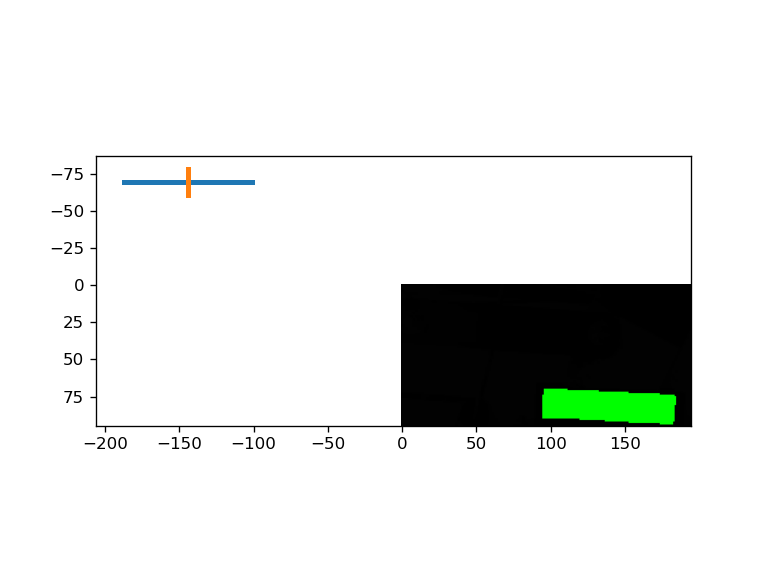

In [24]:
stripe_rot = stripe_loc[0:2,:].T @ Vh[:,0] # rotate stripe onto first principle component
stripeMedian = np.median(stripe_rot) # find median of the stripe
stripe_len = (abs(abs(np.min(stripe_rot)) - abs(np.max(stripe_rot)))) # finds the abs range of the stripe (known length)
scale = knownLength / stripe_len # calculate the pixcel to mm scale
print('The scale used is '+str(scale)+' mm/pixcel')
## plot sample images with the principle componets on it for assesment
stripe_perp = stripe_loc[0:2,:].T @ Vh[:,1] # rotate stripe onto second principle component of stripe to clean
stripe_perp = cleanIQR(perpClean_max,perpClean_min,stripe_perp, True, False) # remove outliers from stripe rot
stripePlot = [stripe_rot.min(),stripe_rot.max(), np.median(stripe_perp), stripe_perp.min(),stripe_perp.max(), stripeMedian]
plt.close()
plt.imshow(check[:, :, 3, :].astype('uint8'))
plt.plot([np.array([stripePlot[0],0]) @ np.linalg.inv(Vh)[1]*-1,
          np.array([stripePlot[1],0]) @ np.linalg.inv(Vh)[1]*-1],
         [np.array([0,stripePlot[2]]) @ np.linalg.inv(Vh)[0]*-1,
          np.array([0,stripePlot[2]]) @ np.linalg.inv(Vh)[0]*-1], linewidth = 3)

plt.plot([np.array([stripePlot[5],0]) @ np.linalg.inv(Vh)[1]*-1,
          np.array([stripePlot[5],0]) @ np.linalg.inv(Vh)[1]*-1],
         [np.array([0,stripePlot[3]]) @ np.linalg.inv(Vh)[0]*-1,
          np.array([0,stripePlot[4]]) @ np.linalg.inv(Vh)[0]*-1], linewidth = 3)

In [25]:
scale = knownLength / stripe_len # calculate the pixcel to mm scale

In [26]:
## Delete variables not required for dot search to free up ram
dot_startNo = len(kmeans.centroids) + stepAfterStripeCluss # # of clusters to start finding the dot cluster
del D
del I
del kmeans
del stripe_rot
del stripe_perp
del stripe_loc

<IPython.core.display.Javascript object>


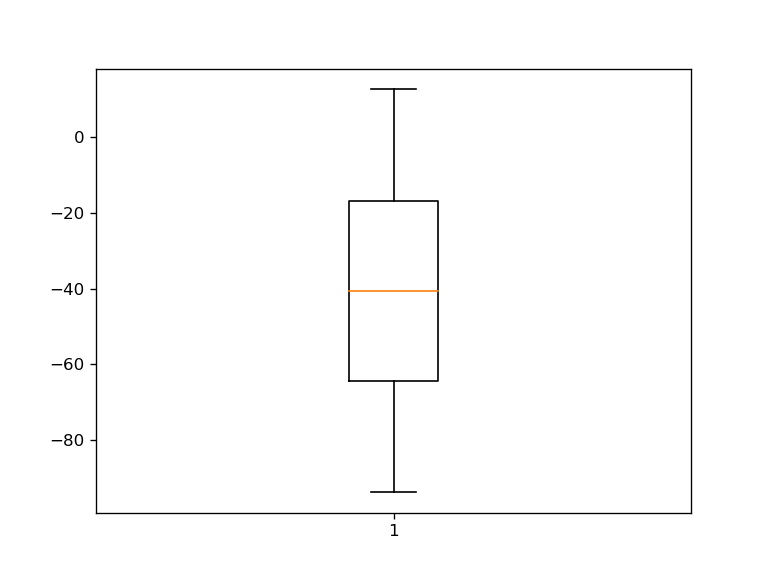

scaled min of dot_search is -1.0
scaled max of dot_search is 1.0


In [27]:
## add the positions projected onto the 2nd principal component to aid in finding dot cluster
dot_search = addInd(w, h, l, pixcels, Vh) # add indices

In [28]:
## Cluster to find dots
D, I, kmeans, dotColour =  faissCluster(dot_search, dotFrac, dot_startNo, it) # perform faiss clustering looking for dot

clustering with 5


Sampling a subset of 1280 / 143957775 for training
Clustering 1280 points in 4D to 5 clusters, redo 1 times, 10 iterations
  Preprocessing in 2.67 s
Cluster Min was 0.09452835736034403s): objective=604.652 imbalance=1.261 nsplit=0       

clustering with 6


Sampling a subset of 1536 / 143957775 for training
Clustering 1536 points in 4D to 6 clusters, redo 1 times, 10 iterations
  Preprocessing in 5.75 s
Cluster Min was 0.027234777697835354): objective=630.873 imbalance=1.215 nsplit=0       



<IPython.core.display.Javascript object>


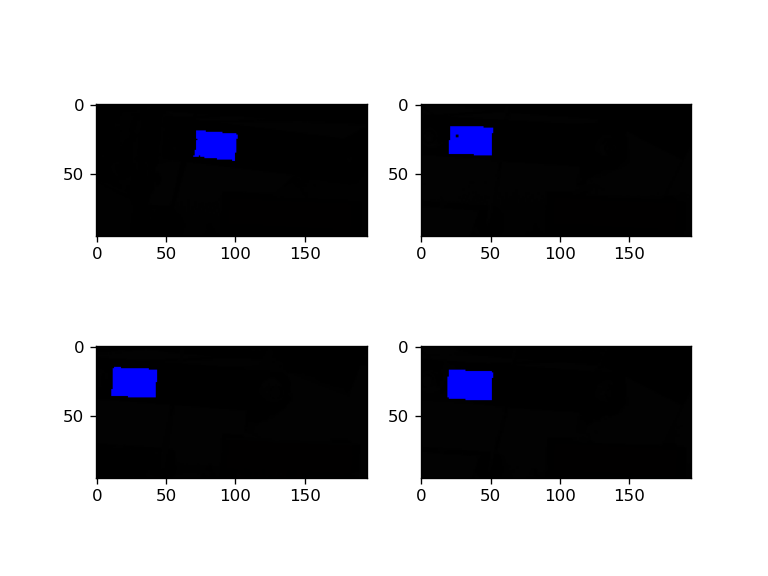

In [62]:
check = clus2Image(I, kmeans.centroids[:,0:3], {int(dotColour[0][0]): [0,0,255]}) # get image array with dot clusters changed to green
check = np.reshape(check[:,0:2], orig_shape) # reshape for plotting
check = check[:,:,sample,:] # reduce to just sample images
plotSamples(check, True, False, False) # plot sample images to check clustering

<IPython.core.display.Javascript object>


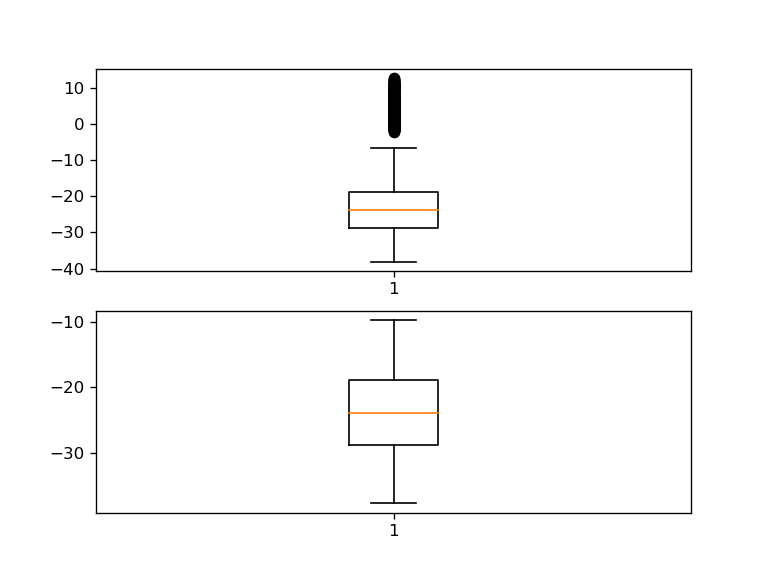

The min projected y value before cleaning is -38.04014332043662
The max projected y value before cleaning is 12.55024692620791
The min projected y value after cleaning is -37.624465991623495
The max projected y value after cleaning is -9.775335536166759


In [63]:
dot_loc = np.array(np.where(np.reshape(I, (h,w,l)) == dotColour)) # get dot locations x,y,l from reshaped labels array
dot_perp = dot_loc[0:2,:].T @ Vh[:,1] # rotate dot x and y onto second principle component of stripe to clean
perp_keep = cleanIQR(85,15,dot_perp, False, True) # get true fals of values to keep in dot_loc based on outliers from dot on the 2nd principle component

In [64]:
## clean dot loc by perp keep
perp_keep = np.reshape(perp_keep,(1,-1)) # make 2d array with 1 row
perp_keep = np.vstack((perp_keep,perp_keep,perp_keep)) # stack logical ontop of itself 3 times to match shape of dot_loc
dot_loc = np.reshape(dot_loc[perp_keep],(3,-1)) # subset dot_loc using perp_keep and return to origninal shape

<IPython.core.display.Javascript object>


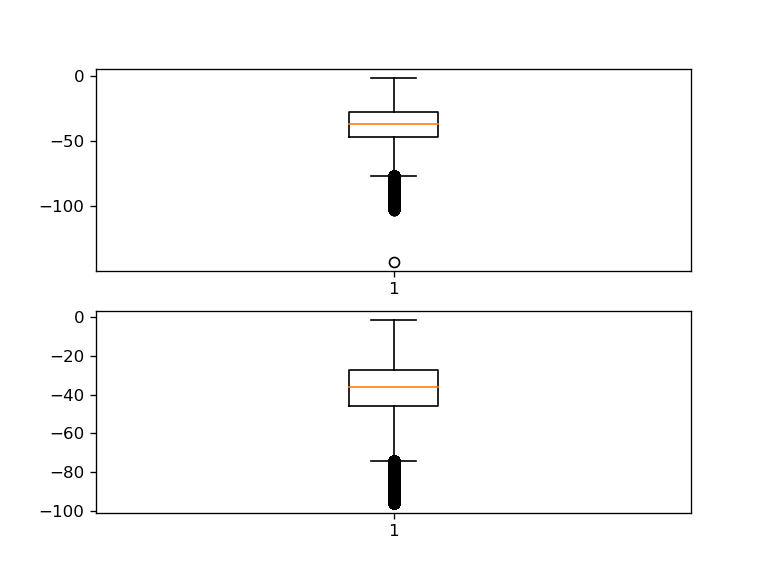

The min projected y value before cleaning is -142.90417215053228
The max projected y value before cleaning is -1.423223878229763
The min projected y value after cleaning is -96.28891737750787
The max projected y value after cleaning is -1.423223878229763


In [65]:
dot_rot = dot_loc[0:2,:].T @ Vh[:,0] # rotate the remianing dost onto first principle component of stripe
rot_keep = cleanIQR(90,10, dot_rot, False, True) # clean dots by IQR

In [66]:
rot_keep = np.reshape(rot_keep,(1,-1)) # reshape to make 2d array with 1 row
rot_keep = np.vstack((rot_keep,rot_keep,rot_keep)) # stack to match shape of dot_loc
dot_loc = np.reshape(dot_loc[rot_keep],(3,-1)) # subset using rot_keep and reshape to original shape

In [67]:
dot_rot = dot_loc[0:2,:].T @ Vh[:,0] # rotate remaining dots onto first principal component
dot_rot = np.vstack((dot_rot,dot_loc[2,:])) # stack the image number and rotated values ontop of eachother
dotsDF = pd.DataFrame(np.transpose(dot_rot), columns=['Dot', 'Pic']) # change fron NP array to data frame for easy grouping

In [122]:
knownLength = -87 # known length of the stripe, negative if measure should get larger when dot is closer to stripe
offset = -127.5 # known zero offset
scale = knownLength / stripe_len # calculate the pixcel to mm scale

In [123]:
dataOut = dotsDF.groupby('Pic').median()

In [124]:
dataOut

,Dot
Pic,
0.0,-39.634738
1.0,-40.068999
2.0,-34.257060
3.0,-40.166037
4.0,-30.168401
...,...
7766.0,-40.147454
7767.0,-29.461610
7768.0,-96.261392


In [125]:
dataOut = dataOut.merge(dotsDF.groupby('Pic').count(), left_index = True, right_index = True)
dataOut = dataOut.merge(pd.DataFrame(file_list), left_index = True, right_index = True)
dataOut = dataOut.merge(pd.DataFrame(timeStamp), left_index = True, right_index = True)
dataOut = dataOut.rename(columns = {'Dot_x' : 'Dot', 'Dot_y': 'Count', '0_x': 'file', '0_y': 'timeStamp'})
dataOut = dataOut[dataOut['Count'] > 0.6*dot_area ] # change back to 0.6
dataOut = dataOut[dataOut['Count'] < 1.4*dot_area ] #change back to 1.4
dataOut['measure'] = ((abs(stripeMedian - dataOut.Dot) * scale) - offset)*1.17
dataOut = dataOut.sort_values('timeStamp')
dataOut.to_csv(out_dir+'vSp_gp.csv')
print("dataOut saved in "+out_dir+'vSp.csv\n\n')
print(str(dataOut.head())+'\n\n')
print(dataOut.describe())

dataOut saved in /mnt/home/9.0 Data Jobs/220420-LR-Sailtesting/vSp.csv


              Dot  Count          file            timeStamp   measure
1534.0 -24.231899    602  G0020005.JPG  2022:04:20 15:04:17  7.084229
5483.0 -24.199553    610  G0020006.JPG  2022:04:20 15:04:18  7.045991
2257.0 -24.278007    610  G0020007.JPG  2022:04:20 15:04:19  7.138736
521.0  -24.264245    616  G0020008.JPG  2022:04:20 15:04:20  7.122467
3053.0 -24.199553    626  G0020009.JPG  2022:04:20 15:04:21  7.045991


               Dot        Count      measure
count  6334.000000  6334.000000  6334.000000
mean    -40.422757   590.996527    26.224180
std      17.728309    63.469470    20.957442
min     -87.053823   343.000000    -0.053993
25%     -41.751847   579.000000    14.085769
50%     -36.393957   611.000000    21.461552
75%     -30.154638   632.000000    27.795358
max     -18.193538   682.000000    81.348887


<IPython.core.display.Javascript object>


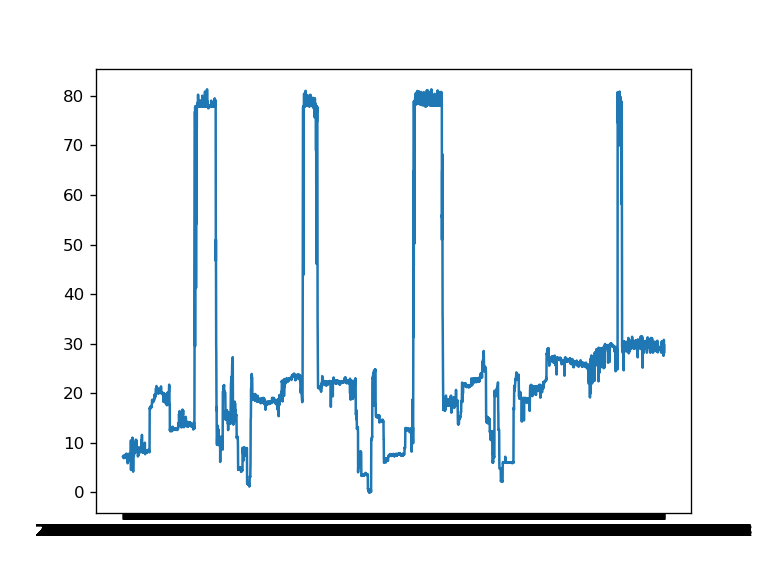

In [126]:
plt.close()
plt.plot(dataOut.timeStamp, dataOut.measure)

In [49]:
dataOut = dotsDF.groupby('Pic').median()
dataOut = dataOut.merge(dotsDF.groupby('Pic').count(), left_index = True, right_index = True)
dataOut = dataOut.merge(pd.DataFrame(file_list), left_index = True, right_index = True)
dataOut = dataOut.merge(pd.DataFrame(timeStamp), left_index = True, right_index = True)
dataOut = dataOut.rename(columns = {'Dot_x' : 'Dot', 'Dot_y': 'Count', '0_x': 'file', '0_y': 'timeStamp'})
dataOut.Count.max()

682

In [ ]:
## Jobs for vSp
# label all plots
# consider adding colour to cluster selector in faiss
# consider if use both clusMin and cluster size closest to expected to identify cluster?? maybe a logical in function call??
# issues when background is variable as other cluster apear that only feature in some images. choose cluster by closeness to orange?? included position??
# how to deal with thousands of phots


## in new script
# import cyclops
# clean and multiply cyclops
# join
# export as loads and positions
# time serries plots and index serries plots with gate fwd HS soft dropped
# correlation matrix plot (ditributions and scatter plots on a grid)
# sailmon cleaner
# sailmon and clyclop combine
# photo loader

## then set up rrp to suit, inc OBA

### then set up for reporting

#### Lens correction

###### Improvements
# colour swab to identify colours
# check colours of selected clusters
# function defining variables
# plot final measurments and clusters
# allow multiple windows / measures
# gpu clustering
# flask app